In [19]:
from sklearn import decomposition
from sklearn import datasets
import sklearn
import os
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as sfm
from patsy import dmatrices
import numpy as np
from sklearn.metrics import mean_squared_error
import random

In [20]:
from utils import *
from pca_analysis import *
from odds_import_df import *

In [21]:
pip list

Package                       Version
----------------------------- --------------
absl-py                       1.4.0
adjustText                    1.1.1
alabaster                     0.7.16
anyio                         4.3.0
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
array_record                  0.5.1
arrow                         1.3.0
asttokens                     2.4.1
async-lru                     2.0.4
attrs                         23.2.0
Babel                         2.14.0
beautifulsoup4                4.12.3
bleach                        6.1.0
certifi                       2024.2.2
cffi                          1.16.0
CHAID                         5.4.1
charset-normalizer            3.3.2
chefboost                     0.0.17
click                         8.1.7
comm                          0.2.2
contourpy                     1.2.1
cycler                        0.12.1
Cython                        3.0.10
debugpy                       1.8.1
deco

## Load diff dataset

In [22]:
current_dir = os.getcwd()
folder = 'data/results_international'
result_file = '/adj_final_results.csv'
rubicology_file = '/all_games_RWC2023_fixed.csv'
split_df = current_dir+'/'+folder+'/split_df_teams.csv'

In [23]:
data = load_data(split_df, draw=True)

print(data.shape)

(94, 38)


In [24]:
data.to_excel(folder+'/split_df_diff.xlsx')

In [25]:
#select one sample from each game
data = data.iloc[::2, :].reset_index(drop=True)

# PCA

In [26]:
variables_to_remove = ['Game ID', 'Date', 'Team', 'Score','Tries', 'Conversions','Goal Kicks Successful', 'Goal Kicks Attempted']
ids = np.array(data['Game ID'])
pca = decomposition.PCA()
#remove the target
y=np.array(data['Outcome'])
y_score = np.array(data['Score'])
X=data.drop(columns=variables_to_remove)
sel  = [[X['Outcome'] == 1], 
        X[X['Outcome'] == 0]] 

X = X.drop(columns = 'Outcome')
#the feature names
features = list(X.columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#fir and transform the  data
X_r = pca.fit_transform(X_scaled)

# Find how many components to keep

In [27]:
eigenvalue_target = 1

cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
#number of components for analysis
over_1 = sum(pca.explained_variance_ >eigenvalue_target)
pca = decomposition.PCA(n_components=over_1)
X_r_selected = pca.fit_transform(X_scaled)
pc_feature = [f'PC{i+1}' for i in range(over_1)]

X_r_selected_df = pd.DataFrame(data=X_r_selected, columns=pc_feature)
print(f'{over_1} components selected explain {np.sum(pca.explained_variance_ratio_)*100:.2f}% of the variance')

8 components selected explain 84.85% of the variance


# Look at the loading for the components

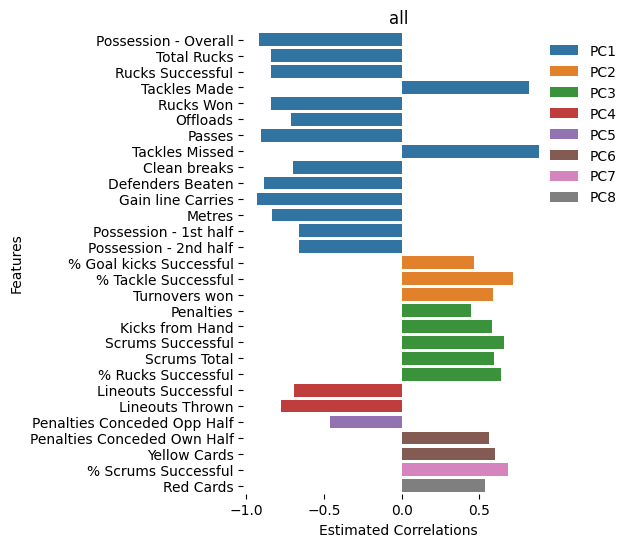

(<Figure size 400x600 with 1 Axes>,
 <Axes: title={'center': 'all'}, xlabel='Estimated Correlations', ylabel='Features'>)

In [28]:
summary_features = summary_loading(pca, features) 
make_pca_component_plot(summary_features)

# Look at the % of variance explained by each Component

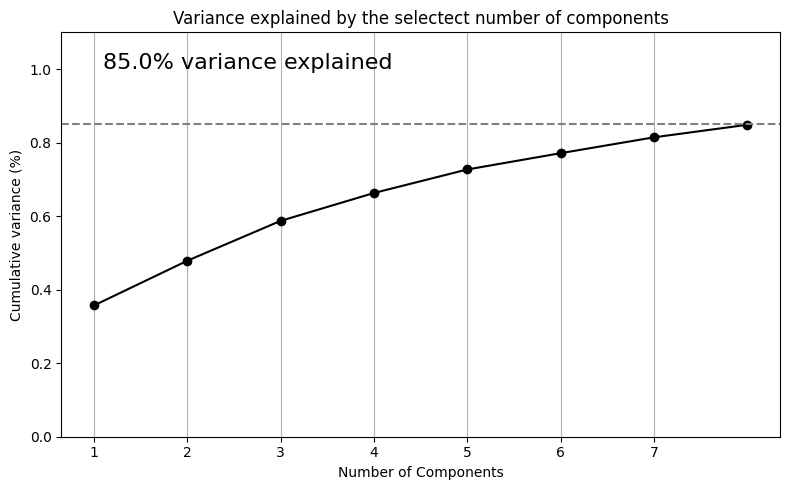

In [29]:
cumulative_variance_explained(pca)

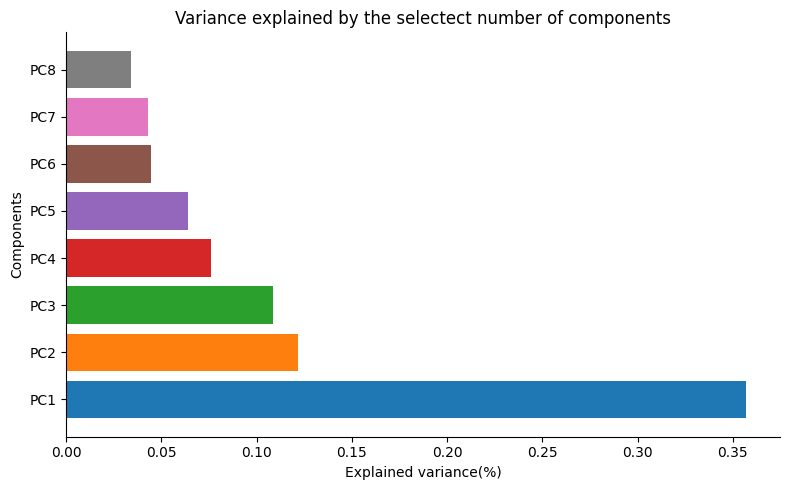

In [30]:
single_component_variance(pca)

# The match outcome prediction

## Logit

In [31]:
logit_model = sm.GLM(y, sm.add_constant(X_r_selected_df), family=sm.families.Binomial())
logit_model  = logit_model.fit()
print(logit_model.summary())
result_df_glm = create_summary_log(logit_model, target= 1)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   47
Model:                            GLM   Df Residuals:                       38
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9.1110
Date:                Sun, 09 Jun 2024   Deviance:                       18.222
Time:                        08:39:04   Pearson chi2:                     41.4
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5037
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2581      1.668      2.553      0.0

In [32]:
result_df_glm.loc[1:]

,Features,params,pvalues,Odds,Percent,0.025,0.975
1,PC1,-0.519076,0.162770,0.595070,-40.493005,0.287093,1.233425
2,PC2,2.299147,0.024071,9.965674,896.567450,1.352152,73.449313
3,PC3,1.927420,0.024428,6.871760,587.175955,1.282351,36.823842
4,PC4,0.239723,0.712844,1.270897,27.089722,0.354551,4.555570
5,PC5,0.327336,0.521132,1.387267,38.726745,0.510375,3.770775
6,PC6,1.241594,0.155986,3.461125,246.112508,0.622700,19.237820
7,PC7,0.463318,0.548353,1.589338,58.933844,0.350085,7.215377
8,PC8,-0.267372,0.698583,0.765388,-23.461207,0.197767,2.962163


# Create Forest plot

/home/arthurg/Advanced_Project/pca_analysis.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(labels)


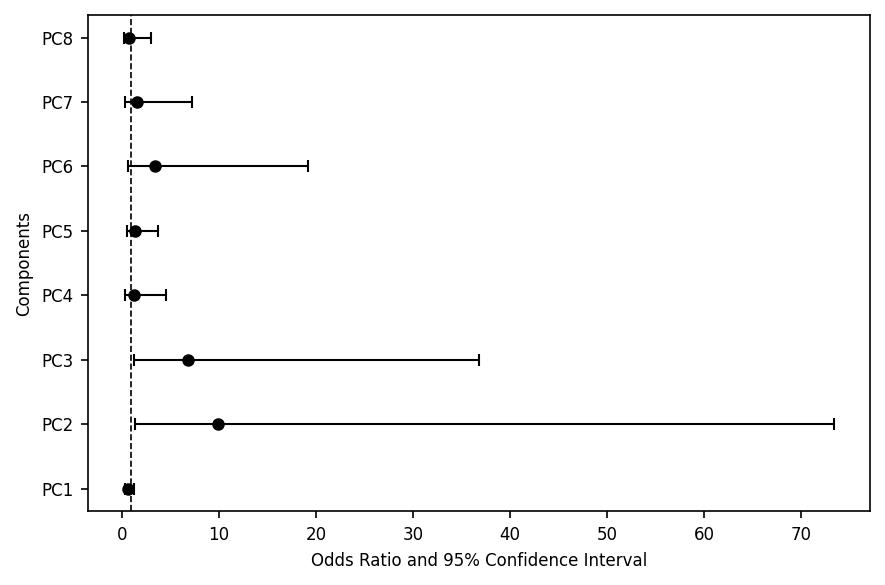

In [33]:
create_forest_plot(result_df_glm.loc[1:] )

### Result with all the components

# testing

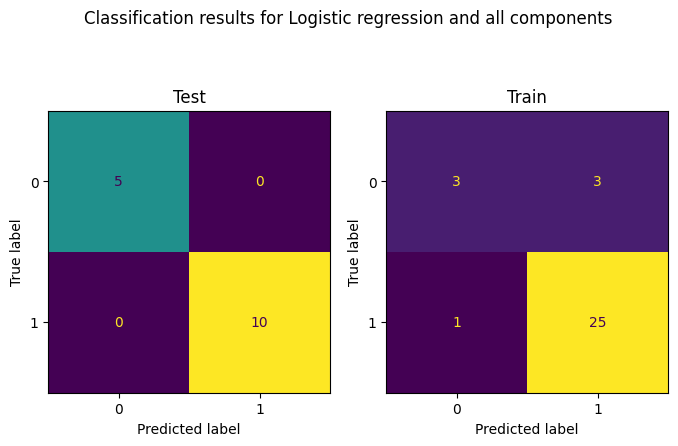

In [34]:
#do the same with training and test 
X_train_log, X_test_log, Y_train_log, Y_test_log = train_test_split(sm.add_constant(X_r_selected_df) , y, test_size = 0.3,stratify=y, random_state = 6)
logit_model_train = sm.GLM( Y_train_log, X_train_log, family=sm.families.Binomial()).fit()

analyse_result(logit_model_train ,sm.add_constant(X_r_selected_df), y)

### Result with only component 2 and 3

# testing

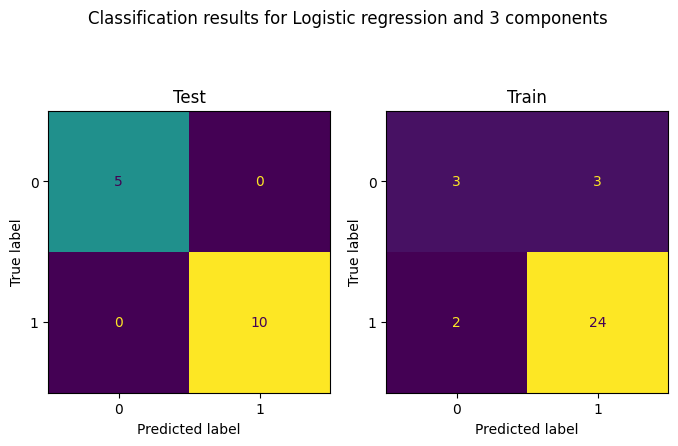

In [35]:
X_r_2_3 = X_r_selected_df[['PC1','PC2', 'PC3']]
X_train_log, X_test_log, Y_train_log, Y_test_log = train_test_split(sm.add_constant(X_r_2_3) , y, test_size = 0.30, stratify=y, random_state = 6)
logit_model_train = sm.GLM( Y_train_log, X_train_log, family=sm.families.Binomial()).fit()

analyse_result(logit_model_train ,sm.add_constant(X_r_2_3),y, n_comp=3)

In [36]:
#Plot the probability of winning again the actual score

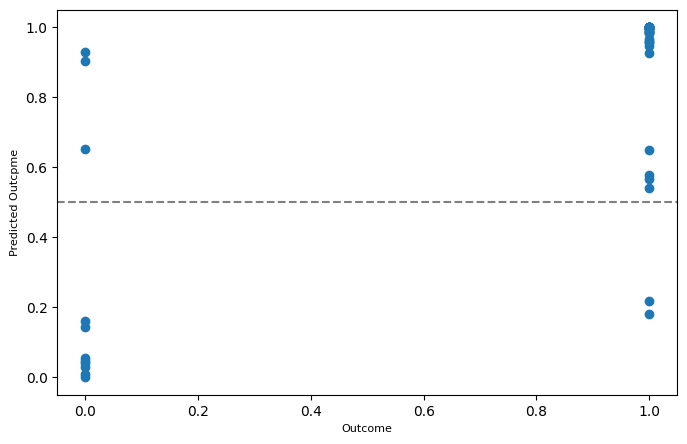

In [37]:
proba_prediction = logit_model_train.predict(sm.add_constant(X_r_2_3))

plt.scatter(y, proba_prediction)
plt.ylabel('Predicted Outcpme', fontsize=8)
plt.xlabel('Outcome', fontsize=8)
plt.axhline(y=0.5, color='grey', linestyle='--')

### Which predictions were horribly wrong?

In [38]:
cutoff = 0.5
error = []
for i in range(len(proba_prediction )):
    if ((y[i]==1) & (proba_prediction[i]<cutoff)) | ((y[i]==0) & (proba_prediction[i]>cutoff)) :
        error.append(i)
#get the game from the dataset
data_error = data.iloc[error]
print(abs(data_error.Score).mean())
data_error

11.0


,Game ID,Date,Team,Score,Possession - Overall,Possession - 1st half,Possession - 2nd half,Tries,Conversions,Penalties,...,Scrums Total,Penalties Conceded Own Half,Penalties Conceded Opp Half,Yellow Cards,Red Cards,% Rucks Successful,% Goal kicks Successful,% Scrums Successful,% Tackle Successful,Outcome
2,87879,21-Oct-2023,England,-1.0,12.0,4.0,18.0,-1.0,-1.0,1.0,...,-1.0,0.0,3.0,0.0,0.0,0.039840,0.000000,-0.446429,-0.030410,0.0
4,87877,15-Oct-2023,France,-1.0,20.0,18.0,20.0,-1.0,-1.0,2.0,...,1.0,-3.0,3.0,-1.0,0.0,0.004551,-0.085714,-0.319444,0.098546,0.0
9,87872,8-Oct-2023,Tonga,21.0,14.0,4.0,26.0,4.0,2.0,-1.0,...,-6.0,3.0,-2.0,0.0,0.0,-0.016858,-0.085714,-0.250000,0.125052,1.0
10,87871,8-Oct-2023,Japan,-12.0,-4.0,-8.0,0.0,-2.0,-1.0,-1.0,...,2.0,-1.0,0.0,1.0,0.0,-0.029583,0.250000,0.375000,0.054090,0.0
17,87864,1-Oct-2023,Australia,20.0,-12.0,4.0,-26.0,3.0,1.0,1.0,...,0.0,2.0,2.0,1.0,0.0,-0.003050,-0.428571,-0.142857,-0.039341,1.0


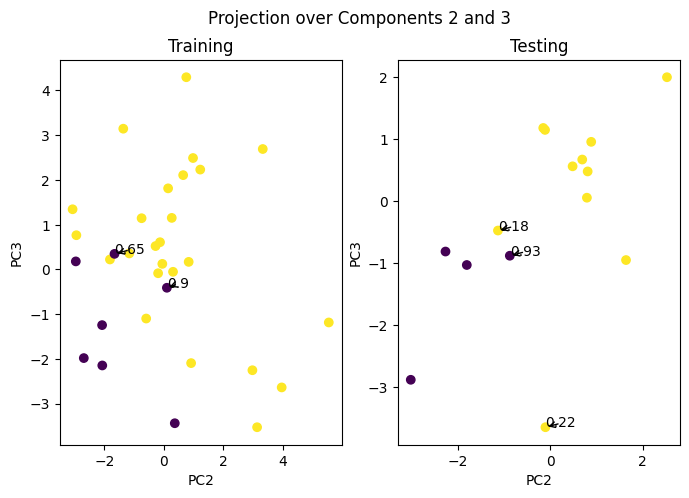

In [40]:
predicted_train = np.array(logit_model_train.predict(X_train_log))
predicted_train_outcome  = [1 if pred >0.5 else 0 for pred in predicted_train ]
predicted_test = np.array(logit_model_train.predict(X_test_log))
predicted_test_outcome  = [1 if pred >0.5 else 0 for pred in predicted_test ]
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Projection over Components 2 and 3')
X_2 = np.array(X_train_log['PC2'])
X_3 = np.array(X_train_log['PC3'])
ax1.scatter(X_2,X_3, c=Y_train_log,)
# Set labels
ax1.set_xlabel('PC2')
ax1.set_ylabel('PC3')
for i in range(len(predicted_train )):
    if predicted_train_outcome[i] != Y_train_log[i]:
        ax1.annotate(predicted_train[i].round(2),(X_2[i], X_3[i]),arrowprops=dict(arrowstyle='->') )

X_2 = np.array(X_test_log['PC2'])
X_3 = np.array(X_test_log['PC3'])
ax1.set_title('Training')
ax2.scatter(X_2,X_3, c=Y_test_log,label='')
# Set labels
ax2.set_xlabel('PC2')
ax2.set_ylabel('PC3')
ax2.set_title('Testing')
#labels for points
for i in range(len(predicted_test )):
    if predicted_test_outcome[i] != Y_test_log[i]:
        ax2.annotate(predicted_test[i].round(2),(X_2[i], X_3[i]),arrowprops=dict(arrowstyle='->') )
plt.savefig('figures/projections.jpg')
plt.show()

## Linear Regression

## with all components

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     18.30
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           2.92e-08
Time:                        08:39:46   Log-Likelihood:                -122.82
No. Observations:                  32   AIC:                             263.6
Df Residuals:                      23   BIC:                             276.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.6073      2.441     10.080      0.0

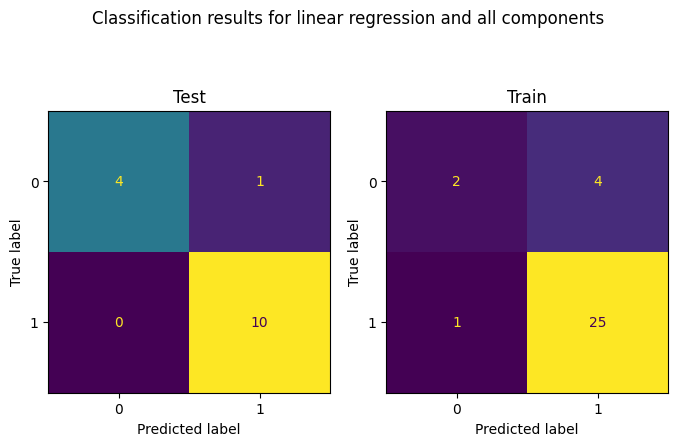

In [41]:
 X_train, X_test, Y_train, Y_test = train_test_split(sm.add_constant(X_r_selected_df) , y_score, test_size = 0.30, random_state = 6)
 
model_all = sm.OLS(Y_train, X_train).fit()
print(model_all.summary())
analyse_result(model_all ,sm.add_constant(X_r_selected_df), y, reg='linear')

# Do backward

In [42]:
backward_df = X_r_selected_df
logit_result = result_df_glm.loc[1:].sort_values(by='pvalues', ascending=False)
pvalue = list(logit_result.pvalues.values)
params= list(logit_result.Features.values)
best_rmse_sm = float('inf')
i=0
best_model_reg= None
y=y_score
while pvalue[i]>0.07:
    selected_df = backward_df.drop(columns=params[i], axis=1)
    columns = selected_df.columns

 
    model = sm.OLS(y, sm.add_constant(selected_df)).fit()
    Y_pred= model.predict(sm.add_constant(selected_df))
    rmse_sm = np.sqrt(mean_squared_error(y, Y_pred ))

    print(rmse_sm, best_rmse_sm, selected_df.shape, params[i])
    if rmse_sm <= best_rmse_sm*1.05:
        best_rmse_sm = rmse_sm 
        best_model_reg = model
        backward_df  = selected_df
    
    i+=1

print(best_model_reg.summary())


11.567844246670608 inf (47, 7) PC4
12.15663208819523 11.567844246670608 (47, 6) PC8
11.755382963466163 11.567844246670608 (47, 6) PC7
11.769051064489174 11.755382963466163 (47, 5) PC5
19.32359702983629 11.769051064489174 (47, 4) PC1
12.451225833852407 11.769051064489174 (47, 4) PC6
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     43.75
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           2.19e-15
Time:                        08:39:49   Log-Likelihood:                -182.57
No. Observations:                  47   AIC:                             377.1
Df Residuals:                      41   BIC:                             388.2
Df Model:                           5                                         
Covari

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     27.14
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           1.53e-09
Time:                        08:39:58   Log-Likelihood:                -125.53
No. Observations:                  32   AIC:                             263.1
Df Residuals:                      26   BIC:                             271.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.0175      2.490     10.048      0.0

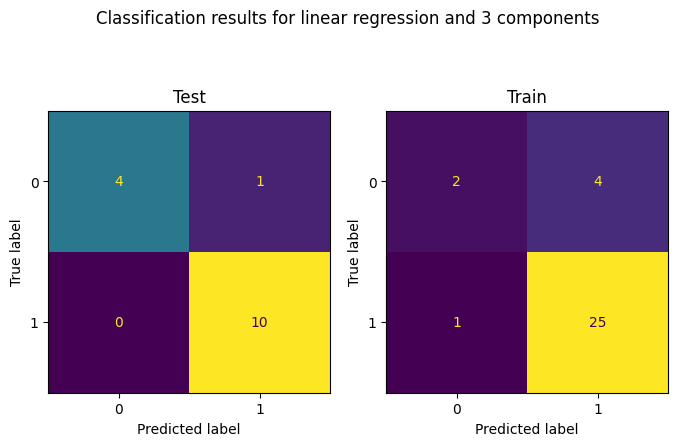

In [44]:
X_r_1_2_3 = X_r_selected_df[['PC1','PC2','PC3','PC6', 'PC8']]
X_train_5, X_test_5, Y_train_5, Y_test_5 = train_test_split(sm.add_constant(X_r_1_2_3) , y_score, test_size = 0.30, random_state = 6)
model_3 = sm.OLS(Y_train_5, X_train_5).fit()
print(model_3.summary())
analyse_result(model_3 ,sm.add_constant(X_r_1_2_3), y, reg='linear', n_comp=3)

## 5 Components


RMSE for training set all components= 11.24
RMSE for testing set all components = 12.83
RMSE for training set 5 components = 12.23
RMSE for testing set 5 components = 11.02


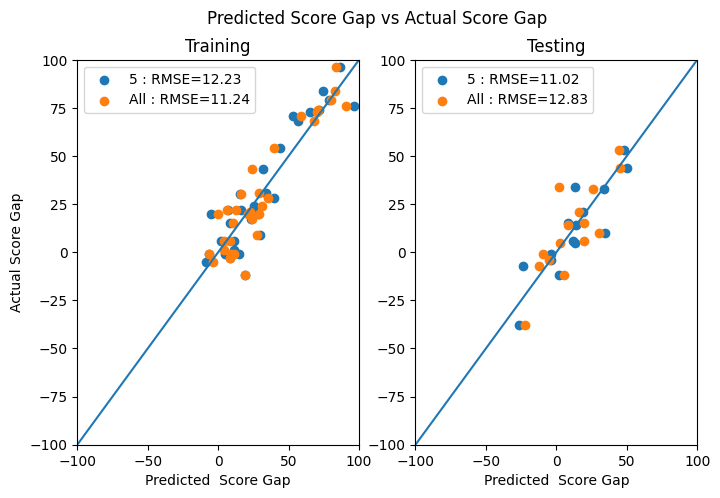

In [45]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Predicted Score Gap vs Actual Score Gap')

y_pred_3_test = model_3.predict(X_test_5)
y_pred_3_train= model_3.predict(X_train_5)

y_pred_all_test = model_all.predict(X_test)
y_pred_all_train= model_all.predict(X_train)



rmse_train = np.sqrt(mean_squared_error(Y_train_5, y_pred_3_train ))
rmse_test = np.sqrt(mean_squared_error(Y_test_5, y_pred_3_test))

rmse_train_all = np.sqrt(mean_squared_error(Y_train, y_pred_all_train ))
rmse_test_all = np.sqrt(mean_squared_error(Y_test, y_pred_all_test ))

print(f'RMSE for training set all components= {rmse_train_all:.2f}')
print(f'RMSE for testing set all components = {rmse_test_all:.2f}')

print(f'RMSE for training set 5 components = {rmse_train:.2f}')
print(f'RMSE for testing set 5 components = {rmse_test:.2f}')

ax2.scatter(y_pred_3_test,Y_test_5, label=f'5 : RMSE={rmse_test:.2f}')
ax2.scatter(y_pred_all_test,Y_test, label=f'All : RMSE={rmse_test_all:.2f}')
ax1.set_title('Training')
ax2.set_title('Testing')
ax1.scatter(y_pred_3_train,Y_train_5, label=f'5 : RMSE={rmse_train:.2f}')
ax1.scatter(y_pred_all_train,Y_train, label = f'All : RMSE={rmse_train_all:.2f}')
ax1.set_xlim(-100, 100)
ax1.set_ylim(-100, 100)
ax2.set_xlim(-100, 100)
ax2.set_ylim(-100, 100)
ax2.set_xlabel('Predicted  Score Gap')
ax1.set_xlabel('Predicted  Score Gap')
ax1.set_ylabel('Actual Score Gap')
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes)
ax2.plot([0, 1], [0, 1], transform=ax2.transAxes)
ax1.legend()
ax2.legend()
plt.savefig('figures/rmse_2.jpeg')
plt.show()

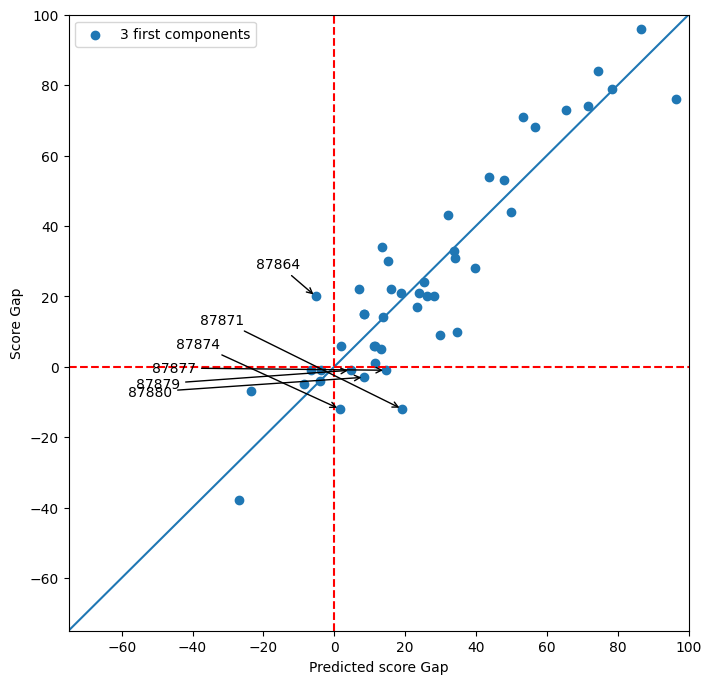

In [96]:
#get presictons for all datset with 3 and all components

y_pred_3 = model_3.predict(sm.add_constant(X_r_1_2_3))

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)

ax.scatter(y_pred_3 , y_score, label='3 first components')
ax.set_xlabel('Predicted score Gap')
ax.set_ylabel('Score Gap')
ax.plot()
#ax.set_title('r^2: 0.59')
custom_xlim = (-75, 100)
custom_ylim = (-75, 100)
ax.legend()
# Setting the values for all axes.
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.axhline(y = 0, color = 'r', linestyle = '--') 
plt.axvline(x = 0, color = 'r', linestyle = '--') 

#annotate the points
errors = []
for i in range(len(y_pred_3)):
    pred_out = y_pred_3[i]>0
    actual = y_score[i]>0
    if pred_out != actual:
        ax.annotate(ids[i],(y_pred_3[i], y_score[i]),arrowprops=dict(arrowstyle='->') ,xytext=(.15+i/100, .35+i/100), textcoords='figure fraction')
        errors.append(i)

'''
pred_logit = logit_model_train.predict(sm.add_constant(X_r_2_3)) 

pred_logit = [1 if pred > 0.5 else 0 for pred in pred_logit ]
for i in range(len(pred_logit )):
    pred_out = pred_logit [i]>0
    actual = y_score[i]>0
    if pred_out != actual:
        ax.annotate(ids[i],(y_pred_3[i], y_score[i]),arrowprops=dict(arrowstyle='->') ,xytext=(.15+i/100, .95+2*i/100), textcoords='figure fraction')
        errors.append(i)
'''
plt.savefig('figures/score_gap_prediction.jpg')

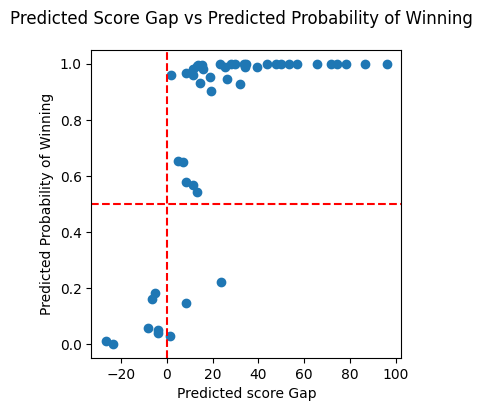

In [97]:
pred_logit = logit_model_train.predict(sm.add_constant(X_r_2_3)) 
fig = plt.figure(figsize=[4, 4])
fig.suptitle('Predicted Score Gap vs Predicted Probability of Winning')
ax = fig.add_subplot(1, 1, 1)

ax.scatter(y_pred_3 , pred_logit)
ax.plot()
plt.axhline(y = 0.5, color = 'r', linestyle = '--') 
plt.axvline(x = 0, color = 'r', linestyle = '--') 
ax.set_xlabel('Predicted score Gap')
ax.set_ylabel('Predicted Probability of Winning')
plt.savefig('figures/pred_winn_vs_score.jpeg')
plt.show()

## Analyse components 2 and 3


def make_pca_component_plot(loading_matrix, components='all', cutoff=0, save=True, filename='figure_feature_loading.png'):
    # Determine the components to plot
    if components == 'all':
        components = loading_matrix.columns.drop(['features', 'highest_pc_column', 'highest_pc']).tolist()
    
    num_components = len(components)
    
    # Calculate the number of rows and columns for the subplots
    num_cols = 2
    num_rows = (num_components + num_cols - 1) // num_cols
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 6))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing
    
    for i, component in enumerate(components):
        ax = axes[i]
        filtered_loading_matrix = loading_matrix[(loading_matrix[component] >= cutoff) | (loading_matrix[component] <= -cutoff)]
        sns.barplot(x=component, y="features", data=filtered_loading_matrix, ax=ax)
        ax.legend(ncol=1, loc="upper left", frameon=False, bbox_to_anchor=(0.95, 1))
        ax.set(ylabel="Features", xlabel="Estimated Correlations")
        ax.set_title(f"Component {i}", fontsize=12)  # Add component name as subtitle
        sns.despine(ax=ax, left=True, bottom=True)
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust the layout to prevent overlap
    plt.tight_layout()
    
    if save:
        fig.savefig('figures/' + filename, bbox_inches='tight')
    
    plt.show()
    return fig, axes

fig1, ax1 = make_pca_component_plot(summary_features,components='all',cutoff=0.5, save=False, filename='pc1_05.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


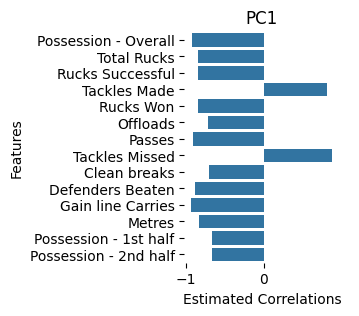

In [98]:
fig1, ax1 = make_pca_component_plot(summary_features,components='PC1',cutoff=0.5, save=True, filename='pc1_05.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


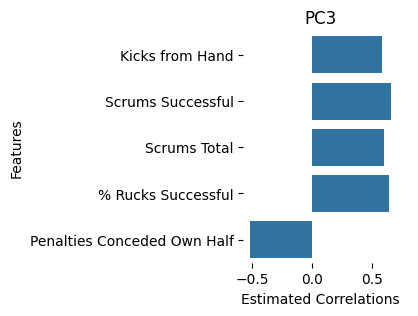

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


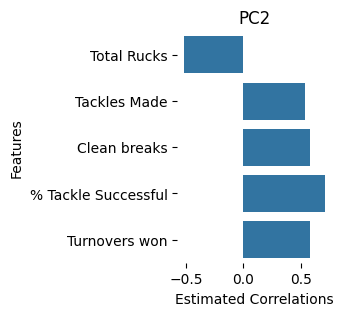

In [99]:
summary_features = summary_loading(pca, features)
plt_3 = make_pca_component_plot(summary_features,components='PC3',cutoff=0.5, save=True, filename='pc3_05.png')
plt_2 = make_pca_component_plot(summary_features,components='PC2',cutoff=0.5, save=True, filename='pc2_05.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


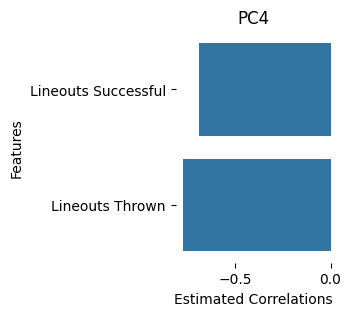

In [100]:
plt_4 = make_pca_component_plot(summary_features,components='PC4',cutoff=0.5, save=True, filename='pc4_05.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


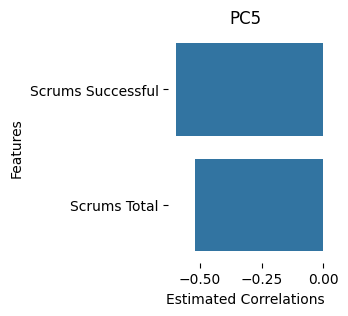

In [101]:
plt_5 = make_pca_component_plot(summary_features,components='PC5',cutoff=0.5, save=True, filename='pc5_05.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


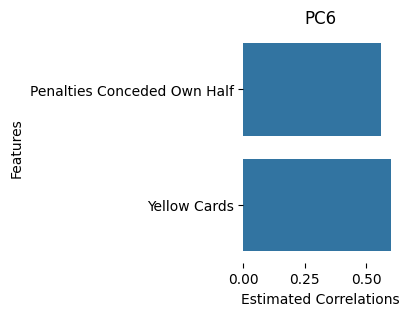

In [102]:
plt_6 = make_pca_component_plot(summary_features,components='PC6',cutoff=0.5, save=True, filename='pc6_05.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


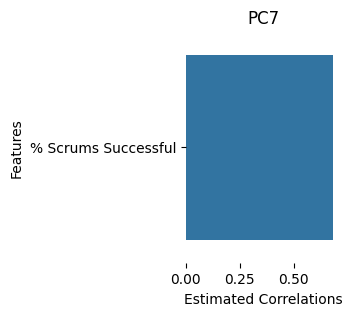

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


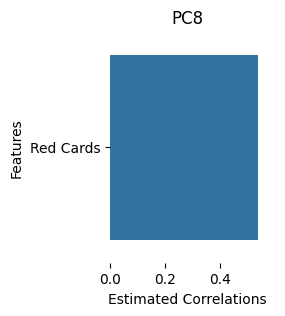

In [103]:
plt_7 = make_pca_component_plot(summary_features,components='PC7',cutoff=0.5, save=True, filename='pc7_05.png')
plt_8 = make_pca_component_plot(summary_features,components='PC8',cutoff=0.5, save=True, filename='pc8_05.png')

## Look at outlier

In [104]:
wc_df = import_odds()
#flip the df so hat the winning team is alway A
def swap_columns(row):
    if row['Score B'] > row['Score A']:
         # Swap 'Team A' and 'Team B'
        row['Team A'], row['Team B'] = row['Team B'], row['Team A']

        # Swap 'Odds A' and 'Odds B'
        row['Odds A'], row['Odds B'] = row['Odds B'], row['Odds A']

        # Swap 'Score A' and 'Score B'
        row['Score A'], row['Score B'] = row['Score B'], row['Score A']
    return row

wc_df = wc_df.apply(lambda row: swap_columns(row), axis=1)
wc_df['Proba_win'] = 1/wc_df['Odds A'] 
wc_df['Proba_loss'] = 1/wc_df['Odds B'] 

# Look at the game should be close:

In [105]:
data['predicted_log']= pred_logit
data['predicted_score'] = y_pred_3

In [106]:
# Remove the draw
wc_2023 = wc_df[(wc_df['Year']==2023) & (wc_df['Team A']!='Hong Kong')]
wc_df_draw = wc_2023[wc_2023['Score A'] != wc_2023['Score B']]
wc_df_draw = wc_df_draw.reset_index(drop=True)

In [107]:
even_games= wc_df_draw [abs(wc_df_draw ['Score A'] - wc_df_draw ['Score B']) < 15]
even_index = list(even_games.index) 
blowout = wc_df_draw [abs(wc_df_draw ['Score A'] - wc_df_draw ['Score B']) > 15]
blowout_index = list(blowout.index) 

In [108]:
# even matches
pred_score = y_pred_3[even_index]
log_score = pred_logit[even_index ]
even_data = data.loc[even_index]

correct_prediction_win = even_data[ (even_data['predicted_log']>0.5) & (even_data['Score']>0)].shape[0]
correct_prediction_loss = even_data[(even_data['predicted_log']<0.5) & (even_data['Score']<0)].shape[0]
total_win = even_data[even_data['Score']>0].shape[0]
total_loss = even_data[even_data['Score']<0].shape[0]
correct_pos = correct_prediction_win /total_win 
correct_neg = correct_prediction_loss /total_loss 
print(f'win :{total_win},loss : {total_loss}, for close encounter TP = {correct_pos}, TN = {correct_neg}')

blowout_data = data.loc[blowout_index]

correct_prediction_win = blowout_data[ (blowout_data['predicted_log']>0.5) & (blowout_data['Score']>0)].shape[0]
correct_prediction_loss = blowout_data[(blowout_data['predicted_log']<0.5) & (blowout_data['Score']<0)].shape[0]
total_win = blowout_data[blowout_data['Score']>0].shape[0]
total_loss = blowout_data[blowout_data['Score']<0].shape[0]
correct_pos = correct_prediction_win /total_win 
correct_neg = correct_prediction_loss /total_loss 
print(f'win :{total_win},loss : {total_loss}, for one_sided encounter TP = {correct_pos}, TN = {correct_neg}')


win :8,loss : 10, for close encounter TP = 1.0, TN = 0.7
win :26,loss : 1, for one_sided encounter TP = 0.9230769230769231, TN = 1.0


# Team where the winning team was not favored

In [109]:
#&(df['score_gap']<=7)
#& (df['Year']==2023)]
#(df['Proba_win']>0.8 )& 
#find game where the win with higest proba did not win
wc_df[(wc_df['Year']==2023)& (wc_df['Proba_win']<0.4 )]

,Team A,Team B,Score A,Score B,Odds A,Odds D,Odds B,Proba_win,Proba_draw,Proba_loss,sum,score_gap,Year
7,Argentina,Wales,29.0,17.0,2.82,23.3,1.47,0.354610,0.042918,0.680272,1.077800,12.0,2023
8,Portugal,Fiji,24.0,23.0,9.87,43.4,1.04,0.101317,0.023041,0.961538,1.085897,1.0,2023
33,Fiji,Australia,22.0,15.0,2.72,24.7,1.48,0.367647,0.040486,0.675676,1.083809,7.0,2023


In [111]:
wc_df[(wc_df['Year']==2023)& (wc_df['score_gap']<5)& (wc_df['Proba_win']>0.8 )]

,Team A,Team B,Score A,Score B,Odds A,Odds D,Odds B,Proba_win,Proba_draw,Proba_loss,sum,score_gap,Year
2,South Africa,England,16.0,15.0,1.18,30.80,5.11,0.847458,0.032468,0.195695,1.075620,1.0,2023
12,England,Samoa,18.0,17.0,1.03,47.00,11.09,0.970874,0.021277,0.090171,1.082322,1.0,2023
28,Georgia,Portugal,18.0,18.0,1.13,34.80,6.15,0.884956,0.028736,0.162602,1.076293,0.0,2023
49,Hong Kong,Kenya,22.0,18.0,1.02,39.43,13.57,0.980392,0.025361,0.073692,1.079446,4.0,2023


# that<s 6 games we will work with

In [112]:
data_upset = load_data(split_df, draw=False)

In [ ]:
ID = [87874, 87873, 87848, 87879, 87869, 87853]

In [ ]:
data_upset = data_upset.iloc[::2, :].reset_index(drop=True)

# what is predicte outcome by or model?

In [ ]:
#find the games in the dataset and predict
variables_to_remove = ['Game ID', 'Date', 'Team', 'Score','Tries', 'Conversions','Goal Kicks Successful', 'Goal Kicks Attempted']

#remove the target
data_upset = data_upset[data_upset['Game ID'].isin(ID)]

In [ ]:
data_upset

In [ ]:
y = np.array(data_upset['Outcome'])
data_upset = data_upset.drop(columns=variables_to_remove)
data_upset = data_upset.drop(columns='Outcome')

In [ ]:
scaled_upset = scaler.transform(data_upset)
scaled_pca = pca.transform(scaled_upset )
scaled_pca = scaled_pca[:,2:4]
predicted_upset = logit_model_train.predict(scaled_pca)

In [ ]:
predicted_upset 

In [ ]:
# can we predict an upset 